## DD2424 deep19 VT19-1 Deep Learning in Data Science - Assignment 3

### Table of Content
[Exercise 1](#Section_1) - Getting the data  
[Exercise 1](#view_images) - Scroll through the images (should run cell to see widget)   
[Exercise 1 - a](#Section_2) - He Initialization with var - 2/n with ReLU activation  
[Exercise 1 - b](#Section_3) - Evaluate Classifier/ Forward Prop  
[Exercise 1](#Section_4) - Compute the cost  
[Exercise 1](#Section_5) - Compute Accuracy  
[Exercise 1 - c](#Section_6) - Compute, check the gradient descent and update weights  
[Exercise 2](#Section_7) - Can I train multi-layer networks?  
[Exercise 2 -a](#cyclic_lr) - Training a 3-layer network with cyclical learning rates   
[Exercise 2 -b](#9l) - Training a 9-layer network with cyclical learning rates   
[Exercise 3 -a](#batchnorm) - Implement batch normalization

[Exercise 2 -a](#training) - Training for Real!  
[Exercise 2 -b](#coarse_fine) - Coarse-to-fine random search  
[Exercise 2 -c](#final_result) - Final model with >50% accuracy!  


### Report
1. Checking the gradient - Calculating numercial gradients and verifying if both are close enough. The difference are in the order or 10^-8 as obtained [here](#grad_check) 



In [39]:
import numpy as np
import math
from PIL import Image as Img
import pickle
from scipy import misc

import sys
import os.path

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pprint
from ipywidgets import *
from IPython.display import Image
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# High quality plots for pdf
ip = get_ipython()
ibe = ip.configurables[-1]
ibe.figure_formats = {'pdf', 'png'}

%load_ext autoreload
%autoreload 2

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Exercise 1  
<a id='Section_1'></a>

## Getting the Data

In [40]:
def LoadBatch(file, size=None):
    """
    Loads all the data from Cifar-10

    Argumets:
    size -- number of samples
    if none returns full dataset

    Returns: 
    train_set_x, train_set_y, valid_set_x, 
    valid_set_y, test_set_x, test_set_y    -- Splits the dataset into 
    classes -- all the labels
    """
    if size:

        # load data
        train_file = file + '/data_batch_1'
        valid_file = file + '/data_batch_2'
        test_file = file + '/test_batch'
        meta_file = file + '/batches.meta'

        with open(train_file, 'rb') as fo:
            train_set = pickle.load(fo, encoding='latin1')
        with open(valid_file, 'rb') as fo:
            valid_set = pickle.load(fo, encoding='latin1')
        with open(test_file, 'rb') as fo:
            test_set = pickle.load(fo, encoding='latin1')
        with open(meta_file, 'rb') as fo:
            meta = pickle.load(fo, encoding='latin1')
        print("Load data " + u'\u2713')

        # data formatting to double
        train_set_x = np.array(train_set["data"][:size], dtype='d')
        train_set_y = np.array(train_set["labels"][:size])
        valid_set_x = np.array(valid_set["data"][:size], dtype='d')
        valid_set_y = np.array(valid_set["labels"][:size])
        test_set_x = np.array(test_set["data"][:size], dtype='d')
        test_set_y = np.array(test_set["labels"][:size])
        classes = np.array(meta["label_names"][:])
        print("Image data to Double " + u'\u2713')

    else:
        with open(file+'/data_batch_1', 'rb') as fo:
            d1 = pickle.load(fo, encoding='latin1')
        with open(file+'/data_batch_2', 'rb') as fo:
            d2 = pickle.load(fo, encoding='latin1')
        with open(file+'/data_batch_3', 'rb') as fo:
            d3 = pickle.load(fo, encoding='latin1')
        with open(file+'/data_batch_4', 'rb') as fo:
            d4 = pickle.load(fo, encoding='latin1')
        with open(file+'/data_batch_5', 'rb') as fo:
            d5 = pickle.load(fo, encoding='latin1')

#         train_set = dict(list(train_set.items())[:45001])
#         valid_set = dict(list(train_set.items())[45001:])
        test_file = file + '/test_batch'
        meta_file = file + '/batches.meta'
        with open(test_file, 'rb') as fo:
            test_set = pickle.load(fo, encoding='latin1')
        with open(meta_file, 'rb') as fo:
            meta = pickle.load(fo, encoding='latin1')
        print("Load data " + u'\u2713')
     # data formatting to double
        train_set_x = np.array(d1["data"][:], dtype='d')
        train_set_y = np.array(d1["labels"][:]).reshape(-1, 1)

        for x in [d2, d3, d4, d5]:
            _data = np.array(x["data"][:], dtype='d')
            _labels = np.array(x["labels"][:]).reshape(-1, 1)

            train_set_x = np.vstack((train_set_x, _data))
            train_set_y = np.vstack((train_set_y, _labels))
        valid_set_x = train_set_x[45000:, :]
        valid_set_y = train_set_y[45000:, :]
        train_set_x = train_set_x[:45000, :]
        train_set_y = train_set_y[:45000, :]

        train_set_y = train_set_y.reshape(-1,)
        valid_set_y = valid_set_y.reshape(-1,)
        test_set_x = np.array(test_set["data"][:], dtype='d')
        test_set_y = np.array(test_set["labels"][:])
        classes = np.array(meta["label_names"][:])
        print("Image data to Double " + u'\u2713')

    # uncomment to get data overview
#     pprint.pprint(train_set)
#     for keys,value in train_set.items():
#         print(keys)

    _ = plt.rcParams['figure.figsize'] = [15, 3]
    _ = plt.subplot(131).set_title("Original")
    ax = sns.distplot(train_set_x[0, :])

    # standardising image data
    train_set_x = train_set_x / 255.
    valid_set_x = valid_set_x / 255.
    test_set_x = test_set_x / 255.
    print("Standardizing image " + u'\u2713')
    _ = plt.subplot(132).set_title("Standardized")
    ax = sns.distplot(train_set_x[0, :])

    # Normalizing image data
    # do by row as this is row and non transformed images
    # For each row i.e 1x3072
    train_mean = np.mean(train_set_x, axis=1).reshape(-1, 1)
    valid_mean = np.mean(valid_set_x, axis=1).reshape(-1, 1)
    test_mean = np.mean(test_set_x, axis=1).reshape(-1, 1)

    train_std = np.std(train_set_x, axis=1).reshape(-1, 1)
    valid_std = np.std(valid_set_x, axis=1).reshape(-1, 1)
    test_std = np.std(test_set_x, axis=1).reshape(-1, 1)

    # mean shape is 10000,1 show repeat 3072
    train_mean = np.tile(train_mean, (1, 3072))
    valid_mean = np.tile(valid_mean, (1, 3072))
    test_mean = np.tile(test_mean, (1, 3072))

    train_std = np.tile(train_std, (1, 3072))
    valid_std = np.tile(valid_std, (1, 3072))
    test_std = np.tile(test_std, (1, 3072))

    train_set_x = (train_set_x - train_mean) / train_std
    valid_set_x = (valid_set_x - valid_mean) / valid_std
    test_set_x = (test_set_x - test_mean) / test_std
    print("Normalizing image " + u'\u2713')

#     _ = plt.subplot(133).set_title("Normalized")
#     ax = sns.distplot(train_set_x[0, :])

    # one-hot encoding labels
    n_values = len(classes)
    train_set_y = np.eye(n_values)[train_set_y]
    valid_set_y = np.eye(n_values)[valid_set_y]
    test_set_y = np.eye(n_values)[test_set_y]
    print('one hot encoding ' + u'\u2713')

    _ = plt.show(ax)

    # reshaping labels
    train_x = train_set_x.transpose()
    valid_x = valid_set_x.transpose()
    test_x = test_set_x.transpose()
    train_y = train_set_y.transpose()
    valid_y = valid_set_y.transpose()
    test_y = test_set_y.transpose()
    print("Reshaping " + u'\u2713')

    if np.unique(np.round(np.mean(train_set_x, axis=1).reshape(-1, 1)))[0] == 0:
        if np.unique(np.round(np.std(train_set_x, axis=1).reshape(-1, 1)))[0] == 1:
            print("Mean 0 and Std. 1" + u'\u2713')

    del train_set_x, train_set_y, valid_set_x, valid_set_y, test_set_x, test_set_y 

    return train_x, train_y, valid_x, valid_y, test_x, test_y, classes

Load data ✓
Image data to Double ✓
Standardizing image ✓
Normalizing image ✓
one hot encoding ✓


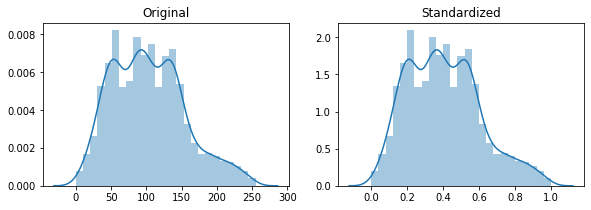

Reshaping ✓
Mean 0 and Std. 1✓


In [41]:
# get the data
train_x, train_y, valid_x, valid_y, test_x, test_y, classes = \
    LoadBatch(os.path.join(os.getcwd(), "..", 'cifar-10'), size=200)

# for training on kaggle
# train_x, train_y, valid_x, valid_y, test_x, test_y, classes = \
#                                 LoadBatch(os.path.join(os.getcwd(), "/kaggle/input/", 'cifar10-python/cifar-10-batches-py'), size=200)

## Sneak peak  into the dataset 

In [42]:
num_train = train_x.shape[1]
num_valid = valid_x.shape[1]
num_test = test_x.shape[1]
num_px = train_x.shape[0]


print("Number of training examples: " + str(num_train))
print("Number of valid examples: " + str(num_valid))
print("Number of testing examples: " + str(num_test))
print("Each image is of size: "+str(num_px))
print("train_x shape: " + str(train_x.shape))
print("train_y shape: " + str(train_y.shape))
print("valid_x shape: " + str(valid_x.shape))
print("valid_y shape: " + str(valid_y.shape))
print("test_x shape: " + str(test_x.shape))
print("test_y shape: " + str(test_y.shape))
print("classes shape :" + str(classes.shape))

Number of training examples: 200
Number of valid examples: 200
Number of testing examples: 200
Each image is of size: 3072
train_x shape: (3072, 200)
train_y shape: (10, 200)
valid_x shape: (3072, 200)
valid_y shape: (10, 200)
test_x shape: (3072, 200)
test_y shape: (10, 200)
classes shape :(10,)


## Check out some pics
<a id='view_images'></a>

In [43]:
def show_image(index):
    """
    Displays images from train_set_x i.e the raw set without dimetionality change

    Arguments -- index of the image from 1-10,000

    Returns -- None, Use slider to view all images
    """
    # for train_set_x
    sample = train_x[:, index]
    sample = sample*255.
    R = sample[0:1024].reshape(32, 32)
    G = sample[1024:2048].reshape(32, 32)
    B = sample[2048:].reshape(32, 32)
    img = np.dstack((R, G, B))
    img = Img.fromarray(img.astype("uint8"))
    plt.imshow(img, interpolation='bicubic')
    label = np.where(train_y[:, index] == 1)
    plt.title(classes[label][0])

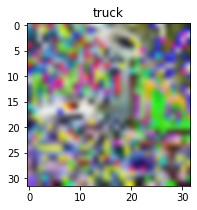

In [44]:
ax = show_image(1)

In [45]:
_ = interact(show_image, index=widgets.IntSlider(
    min=0, max=9999, step=1, value=1))

interactive(children=(IntSlider(value=1, description='index', max=9999), Output()), _dom_classes=('widget-inte…

#### Exercise 1 - a
<a id='Section_2'></a>

## Paramater Initialization

In [46]:
def initialize_parameters(N, layer_dims, he_var=1, BN=False):
    """
    Initialize all the params need for the neural network
    
    Arguments:
    layer_dims -- dims of layers for the NN 
    N -- number of images NN is trained on
    he_var -- parameter for he init.
    BN -- to pass batch norm params

    Returns:
    X -- Input to NN
    Y -- Ground Truth
    parameters -- NN parameters Ws and b(s)
    GDparams -- parameters to control the Gradient descent
    lambd -- regularization co-eff
    m_avg -- for BN
    """

    #Number of possible predictions
    K = len(classes)
    #Subset of data to be trained on
    X = train_x[:, :N]
    Y = train_y[:, :N]
    #Gausssian parameters for W, b
    mu = 0
    parameters = {}
    m_avg = {}

    L = len(layer_dims)
    
    for l in range(1, L):
        # He initialisation
        parameters['W' + str(l)] = np.random.normal(
            loc=mu, scale=(he_var / math.sqrt(layer_dims[l-1])), size=(layer_dims[l], layer_dims[l-1]))
        parameters['b' + str(l)] = np.random.normal(
            loc=mu, scale=(he_var / math.sqrt(layer_dims[l-1])), size=(layer_dims[l], 1))

        if BN:
            parameters['gamma' + str(l)] = np.ones((layer_dims[l], 1))
            parameters['beta' + str(l)] = np.zeros((layer_dims[l], 1))
            m_avg['u' + str(l)] = np.zeros((layer_dims[l], 1))
            m_avg['v' + str(l)] = np.zeros((layer_dims[l], 1))
            
    #regularization co-eff
    lambd = 0
    #n_batch=batch_size NOT the number of batches
    GDparams = {}
    GDparams['n_batch'] = 100
    GDparams['eta'] = 0.001
    GDparams['n_epochs'] = 200
    m_avg['alpha'] = 0.9

    #Get the shapes right
    assert (X.shape == (layer_dims[0], N)), X.shape
    assert (Y.shape == (layer_dims[-1], N))
    assert (classes.size == 10)

    return X, Y, parameters, GDparams, lambd, m_avg

In [66]:
%matplotlib inline
# Constants
N = 10
K = len(classes)
layer_dims = [num_px, 50, 50, K]

# layer_dims = [num_px, 5, 5, K]
X, Y, parameters, GDparams, lambd, _ = initialize_parameters(N, layer_dims)

_ = plt.rcParams['figure.figsize'] = [15, 2*len(layer_dims)]

for ix, param in enumerate(parameters):
    _ = plt.subplot(2, len(layer_dims), ix+1).set_title(param +
                                                        str(parameters[param].shape))
    ax = sns.heatmap(parameters[param])

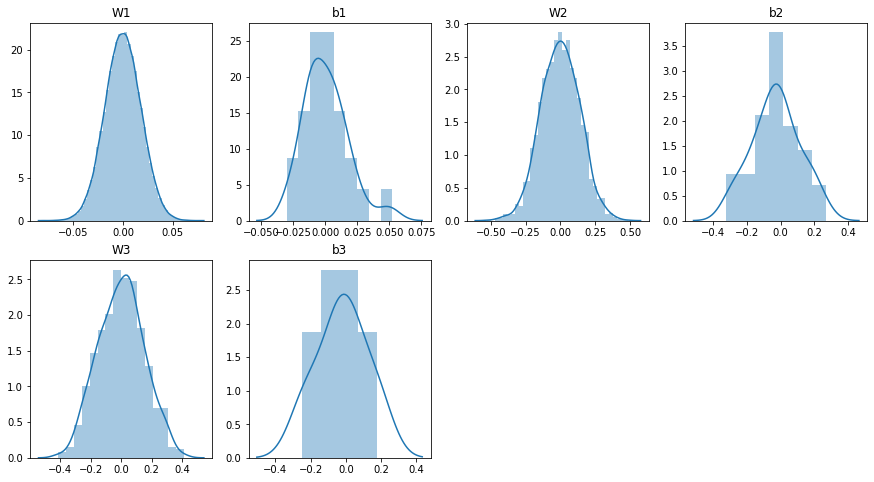

In [67]:
_ = plt.rcParams['figure.figsize'] = [15, 2*len(layer_dims)]

for ix, param in enumerate(parameters):
    _ = plt.subplot(2, len(layer_dims), ix+1).set_title(param)
    ax = sns.distplot(parameters[param].reshape(-1, 1))

####    Exercise 1 - b
<a id='Section_3'></a>


## Forward Propogation

In [68]:
def softmax(x):
    """
    Instead of using np.exp(x)/np.sum(np.exp(x))
    I decrease the value of x with the max, 
    it could be any number as it cancels out when equation is expanded
    This is to avoid overflow due to exponential increase

    Argumets:
    x -- Product W, X

    Returns:
    soft -- softmax(W,X)
    """
    e_x = np.exp(x - np.max(x, axis=0))
    soft = e_x / np.sum(e_x, axis=0)
    return soft


def ReLU(s):
    """
    ReLU activation function

    Arguments:
    s -- Classifier output i.e W*X + b

    Returns:
    array replacing negative values with 0
    """
    return np.where(s < 0, 0, s)


def EvaluateClassifier(X, parameters):
    """
    s1 = W1x + b1 
    h = max(0, s1)
    s = W2h + b2
    p = SOFTMAX(s) 

    Arguments:
    X -- Input data
    Parameters --
        W -- Weights
        b -- bias

    Returns:
    H_dic -- Activation output/ Hidden Layer's output
    P -- Probabilities of each class for each sample in X
    """
    layers = len(parameters)//2
    H_dic = {}
    H = X  # initial h
    for layer in range(1, layers):
        H_dic["H"+str(layer)] = H
        s = np.dot(parameters["W"+str(layer)], H) + parameters["b"+str(layer)]
        H = ReLU(s)
    H_dic["H"+str(layers)] = H
    s = np.dot(parameters["W"+str(layers)], H) + parameters["b"+str(layers)]
    P = softmax(s)

    # Dimensional check -- removed as it conflicts with minibatches
    #assert(X.shape == (d,N)),X.shape
    #assert(P.shape == (K,N))
    return H_dic, P

In [69]:
H_dic, P = EvaluateClassifier(X, parameters)

In [70]:
def visulaize_predictions(P, Y):
    """
    Just an excuse to use the beautiful seaborn :)

    Arguments:
    P -- Probabilties to get the predicitons
    Y -- Ground truth

    Returns:
    None -- Nice plots
    """

    plt.rcParams['figure.figsize'] = [25, 5]
    plt.subplot(141).set_title("Prediction")
    predictions = (P == P.max(axis=0, keepdims=1)).astype(float)
    ax = sns.heatmap(predictions)
    plt.subplot(142).set_title("Ground Truth")
    ax = sns.heatmap(Y)
    plt.subplot(143).set_title("Correct Matches")
    matches = (np.multiply(Y, predictions)).astype(float)
    ax = sns.heatmap(matches)
    plt.subplot(144).set_title("Differences")
    matches = Y + predictions
    ax = sns.heatmap(matches)
    plt.show(ax)

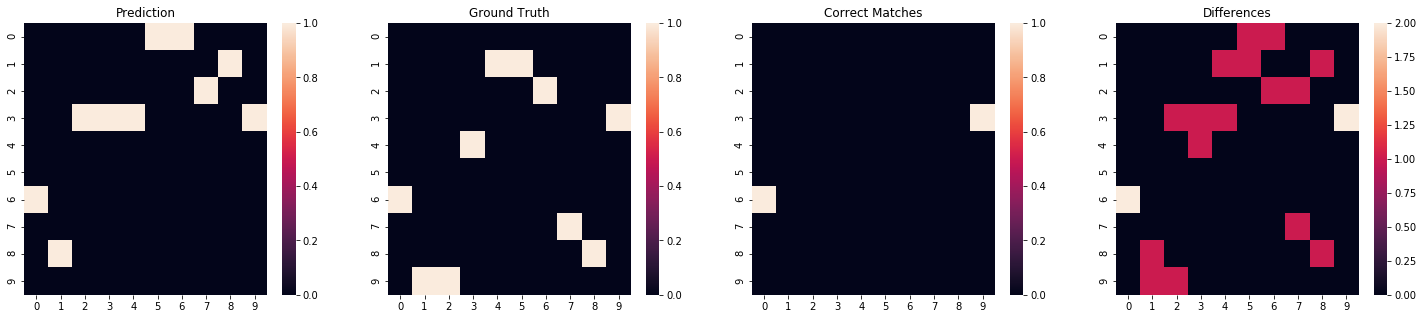

In [71]:
visulaize_predictions(P, Y)

#### Exercise 1
<a id='Section_4'></a>

## Computing the cost

In [72]:
def ComputeCost_CrossEntropy(P, Y, parameters):
    """
    Loss of current state of prediction w.r.t the ground truth

    Arguments:
    P -- Probabilities of each class of each sample in input data
    Y -- Ground truth
    parameters -- 
        W -- Weights that produced the probabilities (Can be used in num. GD as well)

    Returns:
    cost -- sum of crossentropy loss and regularization term
    """

    P = np.reshape(P, (K, -1))
    ground_truth = np.reshape(Y, (K, -1))
    product = np.multiply(Y, P).sum(axis=0)

    # cross entropy loss - Handling -log0 tending to infinity
    product[product == 0] = np.finfo(float).eps  # very low value
    crossEntropyLoss = np.mean(-np.log(product))  # .sum() / N

    sum_sq_W = 0  # sum of squares of weights
    for param in parameters:
        if 'W' in param:
            sum_sq_W += np.power(parameters[param], 2).sum()
    L2_regularization_cost = lambd * sum_sq_W

    cost = crossEntropyLoss + L2_regularization_cost
    return cost

In [73]:
cost = ComputeCost_CrossEntropy(P, Y, parameters)
print(cost)

2.2440038571713288


#### Exercise 1
<a id='Section_5'></a>

## Accuracy of the predictions

In [74]:
def ComputeAccuracy(P, Y):
    """
    instead of using function acc = ComputeAccuracy(X, y, W, b)
    and calculating P again lets use it from the from the prev. output

    Arguments:
    P -- Probabilities of each class
    Y -- Ground Truth

    Returns:
    Accuracy -- Number of matches btw ground truth and predicions from probabilities
    """
    predictions = np.argmax(P, axis=0)
    groundtruth = np.argmax(Y, axis=0)
    matches = np.sum(predictions == groundtruth)
    total = len(predictions)
    accuracy = (matches/float(total))
    assert(P.shape == Y.shape)
    return accuracy

In [75]:
accuracy = ComputeAccuracy(P, Y)
print("Accuracy :" + str(accuracy))

Accuracy :0.2


#### Exercise 1 - c
<a id='Section_6'></a>

## Computing the Gradients

In [76]:
def ComputeGradients(X, Y, P, H_dic, parameters, lambd):
    """ 
    G -- dJ/dZ - g for Batch
    Z -- WX
    grad_W1 -- dJ/dW
    grad_b -- dJ/db
    grad_L -- dJ/dL Regularization term
    grad_W -- dJ/dW + Regularization term

    Argumets:
    X -- input data
    Y -- Ground truth
    P -- current probabilities/ Output Layer's output
    H_dic -- Activation output/ Hidden Layer's output
    parameters -- 
        W -- Current weights that generated the probabilities
        b -- current bias
    lambd -- lambda - Regularization term (to differ from the keyword itself)

    Returns:
    cache -- gradiants of all parameters    
    """

    cache = {}
    for param in parameters:
        cache[param] = np.zeros_like(parameters[param])
    layers = len(parameters)//2

    N = X.shape[1]

    for i in range(N):
        x = X[:, i].reshape(-1, 1)
        y = Y[:, i].reshape(-1, 1)
        p = P[:, i].reshape(-1, 1)
        g = -(y - p)

        for l in reversed(range(1, layers+1)):
            H = H_dic["H"+str(l)]
            h = H[:, i].reshape(-1, 1)

            cache["b"+str(l)] += g
            cache["W"+str(l)] += np.outer(g, h)    # or simply (g.dot(x.T)

            g = np.dot(parameters["W"+str(l)].T, g)
            positiveActivation = np.where(h > 0, 1, 0)
            g = g * positiveActivation

    for grad in cache:
        cache[grad] /= N
        if "W" in grad:
            cache[grad] += 2 * lambd * parameters[grad]  # Regularization term

    return cache

In [77]:
cache = ComputeGradients(X, Y, P, H_dic, parameters, lambd)
# print(np.unique(cache["W1"]))  # just to check if its not null
# print(np.unique(cache["b1"]))

## Gradient Checking

In [78]:
def compute_grads_num(X, Y, parameters, BN=False):
    """
    Numerical gradient descent using finite difference method. 

    Arguments:
    X -- Input dataset/ subset
    Y -- Corresponding Ground Truth
    parameters -- For all layers
        W -- Current Weights
        b -- current bias

    Returns:
    cache -- For all layers
        W -- Numerical Gradient of W  
        b -- Numerical Gradient of b
    """
    N = X.shape[0]
    cache = {}
    for param in parameters:
        cache[param] = np.zeros_like(parameters[param])

    h = 1e-6  # very small number by which you want to vary the params
    if BN:
        H, P, BN_params = EvaluateClassifier_BN(
            X, parameters, training=True, check=True)
    else:
        H, P = EvaluateClassifier(X, parameters)
    c = ComputeCost_CrossEntropy(P, Y, parameters)

    for param in parameters:
        if 'W' in param:
            for i in tqdm(range(parameters[param].shape[0]), desc=param):
                for j in range(parameters[param].shape[1]):
                    # change the weights and see if the cost reduces!
                    parameters[param][i, j] += h
                    if BN:
                        H, P, BN_params = EvaluateClassifier_BN(
                            X, parameters, training=True, check=True)
                    else:
                        # !!!!As ComputeCost_CrossEntropy takes P directly, update it
                        H_dic, P = EvaluateClassifier(X, parameters)
                    c2 = ComputeCost_CrossEntropy(P, Y, parameters)
                    parameters[param][i, j] -= h
                    # if cost decreases, value negative,
                    cache[param][i, j] = (c2-c) / h
                    # hence add this grad to W, ViceVersa
        else:
            for i in tqdm(range(parameters[param].shape[0]), desc=param):
                # change the bias and see if the cost reduces!
                parameters[param][i] += h
                if BN:
                    H, P, BN_params = EvaluateClassifier_BN(
                        X, parameters, training=True, check=True)
                else:
                    # !!!!As ComputeCost_CrossEntropy takes P directly, update it
                    H_dic, P = EvaluateClassifier(X, parameters)
                c2 = ComputeCost_CrossEntropy(P, Y, parameters)
                parameters[param][i] -= h
                cache[param][i] = (c2-c) / h

    return cache

In [ ]:
cacheNum = compute_grads_num(X, Y, parameters)
# print(np.unique(cacheNum["grad_W2"]))    #Sanity check -- just to know they are not all 0's
# print(np.unique(cacheNum["grad_b2"]))

In [80]:
def gradient_check(cache, cacheNum, epsilon):
    """
    Calculating realtive error between analytically and numerically computed gradient
    and checking if they are small. (smaller than epsilon)

    Order of the gradients does not matter

    Arguments:
    cache -- Analytical gradient
    cacheNum -- Numerical gradient
    epsilon -- very small value by which gradNum and gradAnly could differ

    Returns:
    None -- Prints relative error of gradAnly and gradNum
    """
    for param in parameters:
        # Weights
        grad1 = cache[param]
        grad2 = cacheNum[param]
        # Could simply use np.abs(grad1 - grad2).sum()
        difference = np.linalg.norm(grad1 - grad2)
        # varitaion - 2.0988034043225143e-08 only
        summation = np.linalg.norm(grad1) + np.linalg.norm(grad2)
        denominator = max(epsilon, summation)  # to avoid division by 0
        relative_error = difference / denominator

        if relative_error < 1e-6:
            print(u'\u2714  ' + "The gradient for " + param + " is correct! " +
                  str(relative_error))
        else:

            print(u'\u2718  ' + "The gradient for " + param + " is Wrong! " +
                  str(relative_error))
#             print("Relative_error for " + param + " :" + str(relative_error))
#             print(u'\u2718  ' + "The gradient is wrong!")

In [81]:
gradient_check(cache, cacheNum, 1e-6)  # check all gradients

✔  The gradient for W1 is correct! 7.727369826026977e-08
✔  The gradient for b1 is correct! 8.057105068848787e-08
✔  The gradient for W2 is correct! 1.161571037902072e-07
✔  The gradient for b2 is correct! 1.2106012906322097e-07
✔  The gradient for W3 is correct! 2.337387750533701e-07
✔  The gradient for b3 is correct! 3.2904170431835773e-07


 *Notice the increase in the difference between the analytic and gradient from W3 to W1. As mentioned in the instructions, it is the due the addition of the approximations of the backprop from the last layer to the first.*

In [25]:
def update_params(parameters, cache, eta):
    """
    Updating Weights and bias with the calculated gradients

    Arguments:
    parameters -- For all layers
        W -- prev. Weights
        b -- prev. bias
    eta -- learning rate

    Returns:
    parameters -- For all layers
        W -- updated Weights
        b -- updated bias
    """
    for param in parameters:
        parameters[param] = parameters[param] - eta*cache[param]

    return parameters

In [26]:
parameters = update_params(parameters, cache, GDparams['eta'])
print(np.unique(parameters["W1"]))  # just to check the variation
# print(np.unique(parameters["b1"]))
# print(np.unique(parameters["W2"]))
# print(np.unique(parameters["b2"]))

[-0.07076191 -0.06918435 -0.06650111 ...  0.06374877  0.06941497
  0.07101957]


#### Exercise 2 
<a id='Section_7'></a>
### Can I train multi-layer networks?
## Mini Batch Gradient Descent

In [27]:
def get_mini_batches(X, Y, n_batch):
    """
    Convert the whole dataset into smaller chunks

    Arguments:
    X -- Total input data
    Y -- Corresponding ground truth
    n_batch -- Number of samples in each batch (different from number of batches)

    Returns:
    mini_batches -- collection of small datasets each of size atmost n_batch
    """

    mini_batches = []
    X = X.T
    Y = Y.T
    data = np.hstack((X, Y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // n_batch
    i = 0

    # as n_minibatch is floor of data.shape[0]/n_batch
    for i in range(n_minibatches):
        mini_batch = data[i * n_batch:(i + 1)*n_batch, :]
        X_mini = mini_batch[:, :-10]
        # if needed .reshape((mini_batch[0].shape,10))
        Y_mini = mini_batch[:, 3072:]
        mini_batches.append((X_mini, Y_mini))

    if data.shape[0] % n_batch != 0:
        mini_batch = data[(i + 1)*n_batch:data.shape[0], :]
        X_mini = mini_batch[:, :-10]
        # if needed .reshape((mini_batch[0].shape,10))
        Y_mini = mini_batch[:, 3072:]
        mini_batches.append((X_mini, Y_mini))

    import math
    assert(len(mini_batches) == math.ceil(float(X.shape[0])/n_batch))
    return mini_batches

In [28]:
mini_batches = get_mini_batches(X, Y, GDparams['n_batch'])
print("Number of batches :", len(mini_batches))

Number of batches : 1


In [29]:
def MiniBatchGD(X,
                Y,
                X_val,
                Y_val,
                GDparams,
                parameters,
                lambd,
                cyclic_params={},
                debug=False):
    """
    Perform Minibatch gradient descent shuffling at each iteration

    Argumets:
    X -- Total train data
    Y -- corresponding Ground truth
    X_val -- Total validation data
    Y_val -- corresponding Ground truth
    GDparams -- batch size, number of epochs, learning rates
    parameters -- For all layers
        W -- initial Weights
        b -- initial Bias

    Returns:
    parameters -- For all layers
        W -- trained Weights
        b -- trained bias
    """

    # Set up the canvas to do live plotting of the training info
    log = {
        "training loss": [],
        "validation loss": [],
        "training acc": [],
        "validation acc": [],
        "learning rate": []
    }  # using terms cost and loss interchangably
    fig = plt.figure(figsize=(15, 3))  # must include %matplotlib notebook
    Loss = fig.add_subplot(131)
    Accuracy = fig.add_subplot(132)
    Learning_rate = fig.add_subplot(133)

    # plt.ion() #iteractive mode on
    plt.subplot(131).set_title("Loss")
    plt.xlabel('Epoches', axes=Loss)
    plt.ylabel('Loss', axes=Loss)
    plt.subplot(132).set_title("Accuracy")
    plt.xlabel('Epoches', axes=Accuracy)
    plt.ylabel('Accuracy', axes=Accuracy)
    plt.subplot(133).set_title("Learning Rate")
    plt.xlabel('Steps', axes=Learning_rate)
    plt.ylabel('eta', axes=Learning_rate)

    fig.show()
    fig.canvas.draw()

    step = 0  # to display each step accuracy if needed
    l = 0  # to keep track of the cyclic learning rate
    for i in tqdm(range((GDparams['n_epochs']))):  # progress bar

        mini_batches = get_mini_batches(
            X, Y, GDparams['n_batch'])  # shuffled every iteration
        for batch in mini_batches:
            # do transpose again as we did earlier in mini_batch to stack'em up
            X_b = batch[0].T
            Y_b = batch[1].T
            H_dic, P = EvaluateClassifier(
                X_b, parameters)  # Get some predictions of the minibatch
            # no need to calculate for each mini batch
            cost = ComputeCost_CrossEntropy(
                P, Y_b, parameters)  # Get the cost of these predictions
            acc = ComputeAccuracy(P, Y_b)  # Get accuracy of predictions
            cache = ComputeGradients(X_b, Y_b, P, H_dic, parameters,
                                     lambd)  # Learn the mini batch

            if len(cyclic_params) is not 0:
                cyclic_params = cycle_eta(t=step,
                                          l=l,
                                          cyclic_params=cyclic_params,
                                          debug=debug)
                eta = cyclic_params['eta']
                # if current is 2ns then next i.e 2ns+1 is in next cycle
                if step > 0 and \
                   step % (2 * cyclic_params['ns']) is 0:
                    l += 1

            elif len(cyclic_params) is 0:
                eta = GDparams['eta']

            log["learning rate"].append(eta)
            parameters = update_params(parameters, cache,
                                       eta)  # Tune the weights and bias
            #print('Step ' + str(step) + ": Cost:" + str(cost) + " Accuracy: " + str(acc))
            step += 1

        # check performance of new W, b on training data
        H, P_train = EvaluateClassifier(X, parameters)
        log["training loss"].append(
            ComputeCost_CrossEntropy(P_train, Y, parameters))
        log["training acc"].append(ComputeAccuracy(P_train, Y))

        # check performance of new W, b on validation data
        H, P_val = EvaluateClassifier(X_val, parameters)
        log["validation loss"].append(
            ComputeCost_CrossEntropy(P_val, Y_val, parameters))
        log["validation acc"].append(ComputeAccuracy(P_val, Y_val))

        # display the log
        # sns.set() #seaborn for beautiful plots
        # Loss.clear() #clear last epoch's plot
        # Accuracy.clear()
        Loss.plot(log["training loss"], 'c', label="training")
        Loss.plot(log["validation loss"], 'm', label="validation")
        Accuracy.plot(log["training acc"], 'c', label="training")
        Accuracy.plot(log["validation acc"], 'm', label="validation")
        Learning_rate.plot(log["learning rate"], 'b')
        if (i == 0):  # cant get it to work anyother way
            Loss.legend()
            Accuracy.legend()
        fig.canvas.draw()  # draw

    print(step, " steps of training complete!")
    print("Training Accuracy ", log["training acc"][-1], "%")
    print("Training Loss ", log["training loss"][-1])
    print("Validation Accuracy: ", log["validation acc"][-1], "%")
    print("Validation Loss: ", log["validation loss"][-1])

    return parameters

## Testing Mini-Batch by overfitting over small train set

In [ ]:
%matplotlib notebook
#Constants
N = 40
d = num_px
K = len(classes)
layer_dims = [num_px, 50, 50, K]
X, Y, parameters, GDparams, lambd, _ = initialize_parameters(N, layer_dims, he_var=2)
#Overriding the GDparams
GDparams = {}
GDparams['n_batch'] = 10
GDparams['eta'] = 0.01
GDparams['n_epochs'] = 200
lambd = 0
trained_parameters = MiniBatchGD(X, Y, valid_x, valid_y, GDparams, parameters, lambd)

In [ ]:
H, P_test = EvaluateClassifier(test_x, trained_parameters)
print("Loss on the test dataset :",
      ComputeCost_CrossEntropy(P_test, test_y, trained_parameters))
print("Accuracy on the test datset :", ComputeAccuracy(P_test, test_y))

### To visualize False Positives and True Negatives
<a id='bestPredictions'></a>

In [ ]:
%matplotlib inline
visulaize_predictions(P_test,test_y)

 #### Exercise 2 

 ### Implementing cyclical learning rates

In [30]:
def cycle_eta(t, l, cyclic_params, debug=False):
    """
    Function to provide cyclic learning rates

    Arguments:
    t -- Current step count (at time t)
    l -- Current cycle count
    cyclic_params -- Dictionary to keep track of eta curr/min/max and step-size
    ns -- stepsize of the cycle (ns = k * lowerbound(n/nbatch))
          (not to be confused with the training step size)
    """
    # print(t,l,end='\r')
    if (2 * l * cyclic_params['ns'] <= t <= (2 * l + 1) * cyclic_params['ns']):
        if debug:
            print("l:", l, " | ",
                  2 * l *
                  cyclic_params['ns'], t, (2 * l + 1) * cyclic_params['ns'],
                  " increasing ", cyclic_params['eta'], end='\r')

        cyclic_params['eta'] = cyclic_params['eta_min'] + \
            ((t - 2 * l * cyclic_params['ns']) / cyclic_params['ns']) * \
            (cyclic_params['eta_max'] -
             cyclic_params['eta_min'])

    elif ((2 * l + 1) * cyclic_params['ns'] <= t <= 2 *
          (l + 1) * cyclic_params['ns']):
        if debug:
            print("l: ", l, " | ",
                  (2 * l + 1) *
                  cyclic_params['ns'], t, 2 * (l + 1) * cyclic_params['ns'],
                  " decreasing ", cyclic_params['eta'], end='\r')

        cyclic_params['eta'] = cyclic_params['eta_max'] - \
            ((t - (2 * l + 1) * cyclic_params['ns']) / cyclic_params['ns']) * \
            (cyclic_params['eta_max'] -
             cyclic_params['eta_min'])
    else:
        print("t is not between the extremes?")
    return cyclic_params

In [ ]:
%matplotlib inline

cyclic_params = {}
cyclic_params['eta_max'] = 1e-1
cyclic_params['eta_min'] = 1e-5
cyclic_params['eta'] = 1e-5
cyclic_params['ns'] = 500 #ns = k * lowerbound(n/nbatch)
log = []
t = 0
for l in range(3):
    for i in range(cyclic_params['ns']):
        cyclic_params = cycle_eta(t, l, cyclic_params)
        log.append(cyclic_params['eta'])
        t += 1
    for i in range(cyclic_params['ns']):
        cyclic_params = cycle_eta(t, l, cyclic_params)
        log.append(cyclic_params['eta'])
        t += 1
_ = plt.plot(log)
plt.show()

 #### Exercise 2 - a
 <a id='cyclic_lr'></a>

 ### Training a 3-layer network with cyclical learning rates

##### Loading whole data and executing the below methods were performed outside this notebook for computational reasons

In [ ]:
%matplotlib notebook
#Constants
N = 1
d = num_px
K = len(classes)
m = 50
layer_dims = [num_px, 50, 50, K]
X, Y, parameters, GDparams, lambd, _ = initialize_parameters(N, layer_dims, he_var=1)
#Overriding the GDparams
GDparams = {}
GDparams['n_batch'] = 100
GDparams['eta'] = 0.1
GDparams['n_epochs'] = 10
lambd = 0.005

cyclic_params = {}
cyclic_params['eta_max'] = 1e-1
cyclic_params['eta_min'] = 1e-5
cyclic_params['eta'] = 1e-5
cyclic_params['ns'] = 2250 
#cyclic_params[ns] = k * lowerbound(n/nbatch)  
# k=5
trained_parameters = MiniBatchGD(X, Y, valid_x, valid_y, GDparams, parameters, lambd, cyclic_params)

In [ ]:
Image("3l-52acc.png")

In [ ]:
H, P_test = EvaluateClassifier(test_x, trained_parameters)
print("Loss on the test dataset :",
      ComputeCost_CrossEntropy(P_test, test_y, trained_parameters))
print("Accuracy on the test datset :", ComputeAccuracy(P_test, test_y))

In [ ]:
cycle 1  
Training complete!  
Training Accuracy  0.5981777777777778 %  
Training Loss  1.3713625924151995  
Validation Accuracy:  0.5274 %  
Validation Loss:  1.539439955837479  

Loss on the test dataset : 1.5702747806900028  
Accuracy on the test datset : 0.5216  

 #### Exercise 2 - b
 <a id='9l'></a>

 ### Training a 9-layer network with cyclical learning rates

In [ ]:
%matplotlib notebook
#Constants
N = 1
d = num_px
K = len(classes)
m = 50
layer_dims = [num_px, 50, 30, 20, 20, 10, 10, 10, K]

X, Y, parameters, GDparams, lambd, _ = initialize_parameters(N, layer_dims, he_var=1)
#Overriding the GDparams
GDparams = {}
GDparams['n_batch'] = 100
GDparams['eta'] = 0.1
GDparams['n_epochs'] = 10
lambd = 0.005

cyclic_params = {}
cyclic_params['eta_max'] = 1e-1
cyclic_params['eta_min'] = 1e-5
cyclic_params['eta'] = 1e-5
cyclic_params['ns'] = 2250 
#cyclic_params[ns] = k * lowerbound(n/nbatch)  
# k=5
trained_parameters = MiniBatchGD(X, Y, valid_x, valid_y, GDparams, parameters, lambd, cyclic_params)

In [ ]:
Image("9l-45acc.png")

In [ ]:
H, P_test = EvaluateClassifier(test_x, trained_parameters)
print("Loss on the test dataset :",
      ComputeCost_CrossEntropy(P_test, test_y, trained_parameters))
print("Accuracy on the test datset :", ComputeAccuracy(P_test, test_y))

Training complete!  
Training Accuracy  0.5178 %  
Training Loss  1.5820044461245615  
Validation Accuracy:  0.4588 %  
Validation Loss:  1.7574250707465875  

Loss on the test dataset : 1.7695115073682937  
Accuracy on the test datset : 0.4507  

As expected we see quite a drop in the performace of bigger network for the same parameters

 #### Exercise 3
 <a id='batchnorm'></a>
 ### Implement batch normalization and modification of neccessary methods

Augmenting Forward pass with batchnorm

In [31]:
def EvaluateClassifier_BN(X, parameters, training=True, check=False):
    """
    s1 = W1x + b1 
    h = max(0, s1)
    s = W2h + b2
    p = SOFTMAX(s) 

    Arguments:
    X -- Input data
    parameters -- Weights and bias
    training -- triggers mean and var calc.
    check --passing mean and variance as if from training to check forward pass

    Returns:
    H_dic -- Activation output/ Hidden Layer's output
    P -- Probabilities of each class for each sample in X
    """
    layers = len(parameters) // 4
    H_dic = {}
    BN_params = {}
    n = X.shape[1]
    H = X  # initial h

    for layer in range(1, layers):
        H_dic["H" + str(layer)] = H
        s = np.dot(parameters["W" + str(layer)],
                   H) + parameters["b" + str(layer)]
        BN_params["s"+str(layer)] = s

        if check:
            m_avg["u"+str(layer)] = np.mean(s, axis=1, keepdims=True)  # mean
            m_avg["v"+str(layer)] = np.var(s, axis=1,
                                           keepdims=True)*(n-1)/n  # variance

        if training:
            u = np.mean(s, axis=1, keepdims=True)  # mean
            BN_params["u"+str(layer)] = u
            v = np.var(s, axis=1, keepdims=True)*(n-1)/n  # variance
            BN_params["v"+str(layer)] = v

            # updating moving average
            m_avg["u"+str(layer)] = m_avg['alpha'] * \
                m_avg["u"+str(layer)] + (1-m_avg['alpha']) * u
            m_avg["v"+str(layer)] = m_avg['alpha'] * \
                m_avg["v"+str(layer)] + (1-m_avg['alpha']) * v

        else:
            u = m_avg["u"+str(layer)]
            v = m_avg["v"+str(layer)]

#
#        elif args:
#             u = args[0]
#             v = args[1]
#         else:
#             print(
#                 "[Custom Err] During testing pre-computed mean and variance has to be provided",
#                 file=sys.stderr)

        s = batchNormalize(s, u, v)
        BN_params["s_hat" + str(layer)] = s
        s = np.multiply(parameters["gamma" + str(layer)],
                        s) + parameters["beta" + str(layer)]

        H = ReLU(s)

    H_dic["H" + str(layers)] = H
    s = np.dot(parameters["W" + str(layers)],
               H) + parameters["b" + str(layers)]
    P = softmax(s)

    return H_dic, P, BN_params


def batchNormalize(s, u, v):
    """
    Arguments:
    s -- unnormalized scores of the linear transformation function
    u -- mean of s
    v -- Variance of s

    Returns:
    s -- normalized s
    """
    return math.pow(np.diag(v + np.finfo(float).eps), -0.5) * (s - u)

In [32]:
def ComputeGradients_BN(X, Y, P, H_dic, BN_params, parameters, lambd):
    """ 
    G -- dJ/dZ - g for Batch
    Z -- WX
    grad_W1 -- dJ/dW
    grad_b -- dJ/db
    grad_L -- dJ/dL Regularization term
    grad_W -- dJ/dW + Regularization term
    grad_gamma -- dJ/dgamma + Regularization term
    grad_beta -- dJ/dbeta + Regularization term


    Argumets:
    X -- input data
    Y -- Ground truth
    P -- current probabilities/ Output Layer's output
    H_dic -- Activation output/ Hidden Layer's output
    BN_params -- S, S_hat, U, V for BN 
    W -- Current weights that generated the probabilities
    b -- current bias
    lambd -- lambda - Regularization term (to differ from the keyword itself)

    Returns:
    cache -- gradiants of all parameters    
    """

    cache = {}
    for param in parameters:
        cache[param] = np.zeros_like(parameters[param])
    layers = len(parameters) // 4

    N = X.shape[1]

    G = - (Y - P)

    cache["W"+str(layers)] = 1/N * G.dot(H_dic["H"+str(layers)].T) + \
        2 * lambd * parameters["W"+str(layers)]
    cache["b"+str(layers)] = np.reshape(1/N * G.dot(np.ones(N)),
                                        (parameters["b"+str(layers)].shape[0], 1))

    G = parameters["W"+str(layers)].T.dot(G)
    H_dic["H"+str(layers)][H_dic["H"+str(layers)] <= 0] = 0
    G = np.multiply(G, H_dic["H"+str(layers)] > 0)

    for l in reversed(range(1, layers)):
        cache["gamma"+str(l)] = np.reshape(1/N * np.multiply(G,
                                                             BN_params["s_hat"+str(l)]).dot(np.ones(N)), (cache["gamma"+str(l)].shape[0], 1))
        cache["beta"+str(l)] = np.reshape(1/N * G.dot(
                                          np.ones(N)), (cache["beta"+str(l)].shape[0], 1))
        G = np.multiply(G, parameters["gamma"+str(l)])
        G = BatchNormBackPass(
            G, BN_params["s"+str(l)], BN_params["u"+str(l)], BN_params["v"+str(l)])
        cache["W"+str(l)] = 1/N * G.dot(H_dic["H"+str(l)].T) + \
            2 * lambd * parameters["W"+str(l)]
        cache["b"+str(l)] = np.reshape(1/N * G.dot(np.ones(N)),
                                       (cache["b"+str(l)].shape[0], 1))
        if l > 1:
            G = parameters["W"+str(l)].T.dot(G)
            H_dic["H"+str(l)][H_dic["H"+str(l)] <= 0] = 0
            G = np.multiply(G, H_dic["H"+str(l)] > 0)

    return cache


def BatchNormBackPass(G, S_batch, u, v):

    N = G.shape[1]
    sigma1 = np.power(v + np.finfo(np.float64).eps, -0.5)
    sigma2 = np.power(v + np.finfo(np.float64).eps, -1.5)

    G1 = np.multiply(G, sigma1)
    G2 = np.multiply(G, sigma2)

    D = S_batch - u

    c = np.sum(np.multiply(G2, D), axis=1, keepdims=True)

    G = G1 - 1/N * np.sum(G1, axis=1, keepdims=True) - \
        1/N * np.multiply(D, c)

    return G

In [33]:
N = 10
layer_dims = [num_px, 5, 5, K]
X, Y, parameters, GDparams, lambd, m_avg = initialize_parameters(
    N, layer_dims, he_var=1, BN=True)
H_dic, P, BN_params = EvaluateClassifier_BN(
    X, parameters, training=True, check=True)
# print("N:",N," L:",len(layer_dims)," P:",  P.shape)
cache = ComputeGradients_BN(X, Y, P, H_dic, BN_params, parameters, lambd)
print(np.unique(cache["W1"]))  # just to check if its not null
print(np.unique(cache["b1"]))

[-1.03048793 -0.94704051 -0.92579665 ...  0.87434109  0.90073228
  0.93822339]
[-1.11022302e-17  0.00000000e+00  4.44089210e-17]


In [ ]:
cacheNum = compute_grads_num(X, Y, parameters, BN=True)

<a id='batchnorm_gradient'></a>
### Check Gradients with Batch Norm

In [35]:
gradient_check(cache, cacheNum, 1e-6)  # check all gradients

✘  The gradient for W1 is Wrong! 0.7322815077993798
✘  The gradient for b1 is Wrong! 0.0006280370070248983
✘  The gradient for gamma1 is Wrong! 0.49265395231040127
✘  The gradient for beta1 is Wrong! 0.363505381236162
✘  The gradient for W2 is Wrong! 0.45094750466349626
✘  The gradient for b2 is Wrong! 0.0009930137767367878
✔  The gradient for gamma2 is correct! 9.158801555776278e-08
✔  The gradient for beta2 is correct! 2.1631844902060464e-07
✔  The gradient for W3 is correct! 1.7183622491893611e-07
✔  The gradient for b3 is correct! 2.894795598232596e-07
✘  The gradient for gamma3 is Wrong! 0.0014043333874306806
✘  The gradient for beta3 is Wrong! 0.0014043333874306806


<a id='Mini_batchGD with BN'></a>

### Check Gradients with Batch Norm

In [36]:
def MiniBatchGD_BN(X,
                   Y,
                   X_val,
                   Y_val,
                   GDparams,
                   parameters,
                   lambd,
                   cyclic_params={},
                   debug=False):
    """
    Perform Minibatch gradient descent shuffling at each iteration

    Argumets:
    X -- Total train data
    Y -- corresponding Ground truth
    X_val -- Total validation data
    Y_val -- corresponding Ground truth
    GDparams -- batch size, number of epochs, learning rates
    parameters -- For all layers
        W -- initial Weights
        b -- initial Bias

    Returns:
    parameters -- For all layers
        W -- trained Weights
        b -- trained bias
    """

    # Set up the canvas to do live plotting of the training info
    log = {
        "training loss": [],
        "validation loss": [],
        "training acc": [],
        "validation acc": [],
        "learning rate": []
    }  # using terms cost and loss interchangably
    fig = plt.figure(figsize=(15, 3))  # must include %matplotlib notebook
    Loss = fig.add_subplot(131)
    Accuracy = fig.add_subplot(132)
    Learning_rate = fig.add_subplot(133)

    # plt.ion() #iteractive mode on
    plt.subplot(131).set_title("Loss")
    plt.xlabel('Epoches', axes=Loss)
    plt.ylabel('Loss', axes=Loss)
    plt.subplot(132).set_title("Accuracy")
    plt.xlabel('Epoches', axes=Accuracy)
    plt.ylabel('Accuracy', axes=Accuracy)
    plt.subplot(133).set_title("Learning Rate")
    plt.xlabel('Steps', axes=Learning_rate)
    plt.ylabel('eta', axes=Learning_rate)

    fig.show()
    fig.canvas.draw()

    step = 0  # to display each step accuracy if needed
    l = 0  # to keep track of the cyclic learning rate
    for i in tqdm(range((GDparams['n_epochs']))):  # progress bar

        mini_batches = get_mini_batches(
            X, Y, GDparams['n_batch'])  # shuffled every iteration
        for batch in mini_batches:
            # do transpose again as we did earlier in mini_batch to stack'em up
            X_b = batch[0].T
            Y_b = batch[1].T
            # Get some predictions of the minibatch
            """H_dic, P = EvaluateClassifier(
                X_b, parameters)"""
            H_dic, P, BN_params = EvaluateClassifier_BN(
                X_b, parameters, training=True, check=False)
            # no need to calculate for each mini batch
            cost = ComputeCost_CrossEntropy(
                P, Y_b, parameters)  # Get the cost of these predictions
            acc = ComputeAccuracy(P, Y_b)  # Get accuracy of predictions
            """cache = ComputeGradients(X_b, Y_b, P, H_dic, parameters,
                                     lambd)"""
            cache = ComputeGradients_BN(
                X_b, Y_b, P, H_dic, BN_params, parameters, lambd)  # Learn the mini batch

            if len(cyclic_params) is not 0:
                cyclic_params = cycle_eta(t=step,
                                          l=l,
                                          cyclic_params=cyclic_params,
                                          debug=debug)
                eta = cyclic_params['eta']
                # if current is 2ns then next i.e 2ns+1 is in next cycle
                if step > 0 and \
                   step % (2 * cyclic_params['ns']) is 0:
                    l += 1
                    print("cycle", l)

            elif len(cyclic_params) is 0:
                eta = GDparams['eta']

            log["learning rate"].append(eta)
            parameters = update_params(parameters, cache,
                                       eta)  # Tune the weights and bias
            # print('Step ' + str(step) + ": Cost:" + str(cost) + " Accuracy: " + str(acc))
            step += 1

        # check performance of new W, b on training data
        """ H, P_train = EvaluateClassifier(X, parameters)"""

        H, P_train, BN_params = EvaluateClassifier_BN(
                X, parameters, training=False, check=False)
        log["training loss"].append(
            ComputeCost_CrossEntropy(P_train, Y, parameters))
        log["training acc"].append(ComputeAccuracy(P_train, Y))

        # check performance of new W, b on validation data
        """H, P_val = EvaluateClassifier(X_val, parameters)"""
        H, P_val, BN_params = EvaluateClassifier_BN(
                X_val, parameters, training=False, check=False)
        log["validation loss"].append(
            ComputeCost_CrossEntropy(P_val, Y_val, parameters))
        log["validation acc"].append(ComputeAccuracy(P_val, Y_val))

        # display the log
        # sns.set() #seaborn for beautiful plots
        # Loss.clear() #clear last epoch's plot
        # Accuracy.clear()
        Loss.plot(log["training loss"], 'c', label="training")
        Loss.plot(log["validation loss"], 'm', label="validation")
        Accuracy.plot(log["training acc"], 'c', label="training")
        Accuracy.plot(log["validation acc"], 'm', label="validation")
        Learning_rate.plot(log["learning rate"], 'b')
        if (i == 0):  # cant get it to work anyother way
            Loss.legend()
            Accuracy.legend()
        fig.canvas.draw()  # draw

    print(step, " steps of training complete!")
    print("Training Accuracy ", log["training acc"][-1], "%")
    print("Training Loss ", log["training loss"][-1])
    print("Validation Accuracy: ", log["validation acc"][-1], "%")
    print("Validation Loss: ", log["validation loss"][-1])

    return parameters

In [37]:
# train_x, train_y, valid_x, valid_y, test_x, test_y, classes = \
#     LoadBatch(os.path.join(os.getcwd(), "..", 'cifar-10'))

In [ ]:
%matplotlib notebook

# Constants
N = 45000
d = num_px
K = len(classes)
layer_dims = [num_px, 50, 50, K]
X, Y, parameters, GDparams, lambd, m_avg = initialize_parameters(
    N, layer_dims, he_var=2, BN=True)

# Overriding the GDparams
GDparams = {}
GDparams['n_batch'] = 100
GDparams['eta'] = 0.01
GDparams['n_epochs'] = 20
lambd = 0.005


cyclic_params = {}
cyclic_params['eta_max'] = 1e-1
cyclic_params['eta_min'] = 1e-5
cyclic_params['eta'] = 1e-5
cyclic_params['ns'] = 2250 
#cyclic_params[ns] = k * lowerbound(n/nbatch)

trained_parameters = MiniBatchGD_BN(
    X, Y, valid_x, valid_y, GDparams, parameters, lambd, cyclic_params)

In [ ]:
H, P_test, BN_params = EvaluateClassifier_BN(
    test_x, trained_parameters, training=False, check=False)
print("Loss on the test dataset :",
      ComputeCost_CrossEntropy(P_test, test_y, trained_parameters))
print("Accuracy on the test datset :", ComputeAccuracy(P_test, test_y))